In [1]:
"""
This script is used for plotting the metrics saved during training. 
All evaluation metrics can be plotted in real-time.
Copyright (c) 2023 Global Health Labs, Inc
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mgimg
import os
from scipy.signal import savgol_filter

from sklearn.decomposition import PCA
from generate import generate_fake
from CNN.feature_inference import positive_score
import torch

2023-08-29 00:12:48.574189: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
##### Configurations #####

# pre-trained feature detector path
CNN_model_path = '/workspace/data/EndorTeamArea/yumh/GAN_paper/CNN/saved-model-34-0.9133.hdf5'

# Parameters used for GAN model
params = {
    'nz':100,
    'ngf':64,
    'nc':1,
    'gpu':1
}

# epoch number of the GAN model
epoch_n = 100

# The model directory genereated by GAN training scripts 
G_model = '/workspace/code/output/2022-09-08-imageSize:256-batchSize:16-nz:100-lr_g:1e-05-lr_d:5e-06-Seed:855-Iter:200-Ratio:0.75'

In [3]:
def find_maximum_odd_numebr(n):
    # this function will return the biggest odd number larger or equal to n
    if n%2==0:
        return n-1
    else:
        return n

In [4]:
def score_loader(output_dir):
    # load the validation data
    score_tr = np.load(os.path.join(output_dir,'score_tr_ep.npy'))

    # implement the averaging metrics, which takes the average score of all feature space
    avg = []
    for score in score_tr:
        s = []
        offset = 1
        loss_num = 7
        s.append((score[0*loss_num+offset]+score[1*loss_num+offset]+score[2*loss_num+offset]+score[3*loss_num+offset])/4.0) # mmd
        offset=2
        s.append((score[0*loss_num+offset]+score[1*loss_num+offset]+score[2*loss_num+offset]+score[3*loss_num+offset])/4.0) # 1nn acc
        offset=3
        s.append((score[0*loss_num+offset]+score[1*loss_num+offset]+score[2*loss_num+offset]+score[3*loss_num+offset])/4.0) # real acc
        offset=4
        s.append((score[0*loss_num+offset]+score[1*loss_num+offset]+score[2*loss_num+offset]+score[3*loss_num+offset])/4.0) # fake acc
        avg.append(np.array(s))
    avg = np.array(avg)
    
    return score_tr,avg

In [5]:
def representation_loader(output_dir):
    pca_f = {}
    res={}
    pca_f['fake']={}
    res['fake']={}
    pca_f['real']={}
    res['real']={}
    
    for feature in ['conv','pixl','logit','smax']:
        file_name='feature_'+feature+'.pth'
        f1 = torch.load(os.path.join(output_dir,'real',file_name))
        f1 = f1.detach().numpy()
        res['real'][feature]=f1
        pca = PCA(n_components=2)
        pca = pca.fit(f1)
        f = pca.transform(f1)
        pca_f['real'][feature]=f
        
        f2 = torch.load(os.path.join(output_dir,'fake',file_name))
        f2 = f2.detach().numpy()
        res['fake'][feature]=f2
        f_fake = pca.transform(f2)
        pca_f['fake'][feature]=f_fake
        
    return pca_f,res

In [6]:
score_tr,avg = score_loader(G_model)
pca_f,res= representation_loader(G_model)

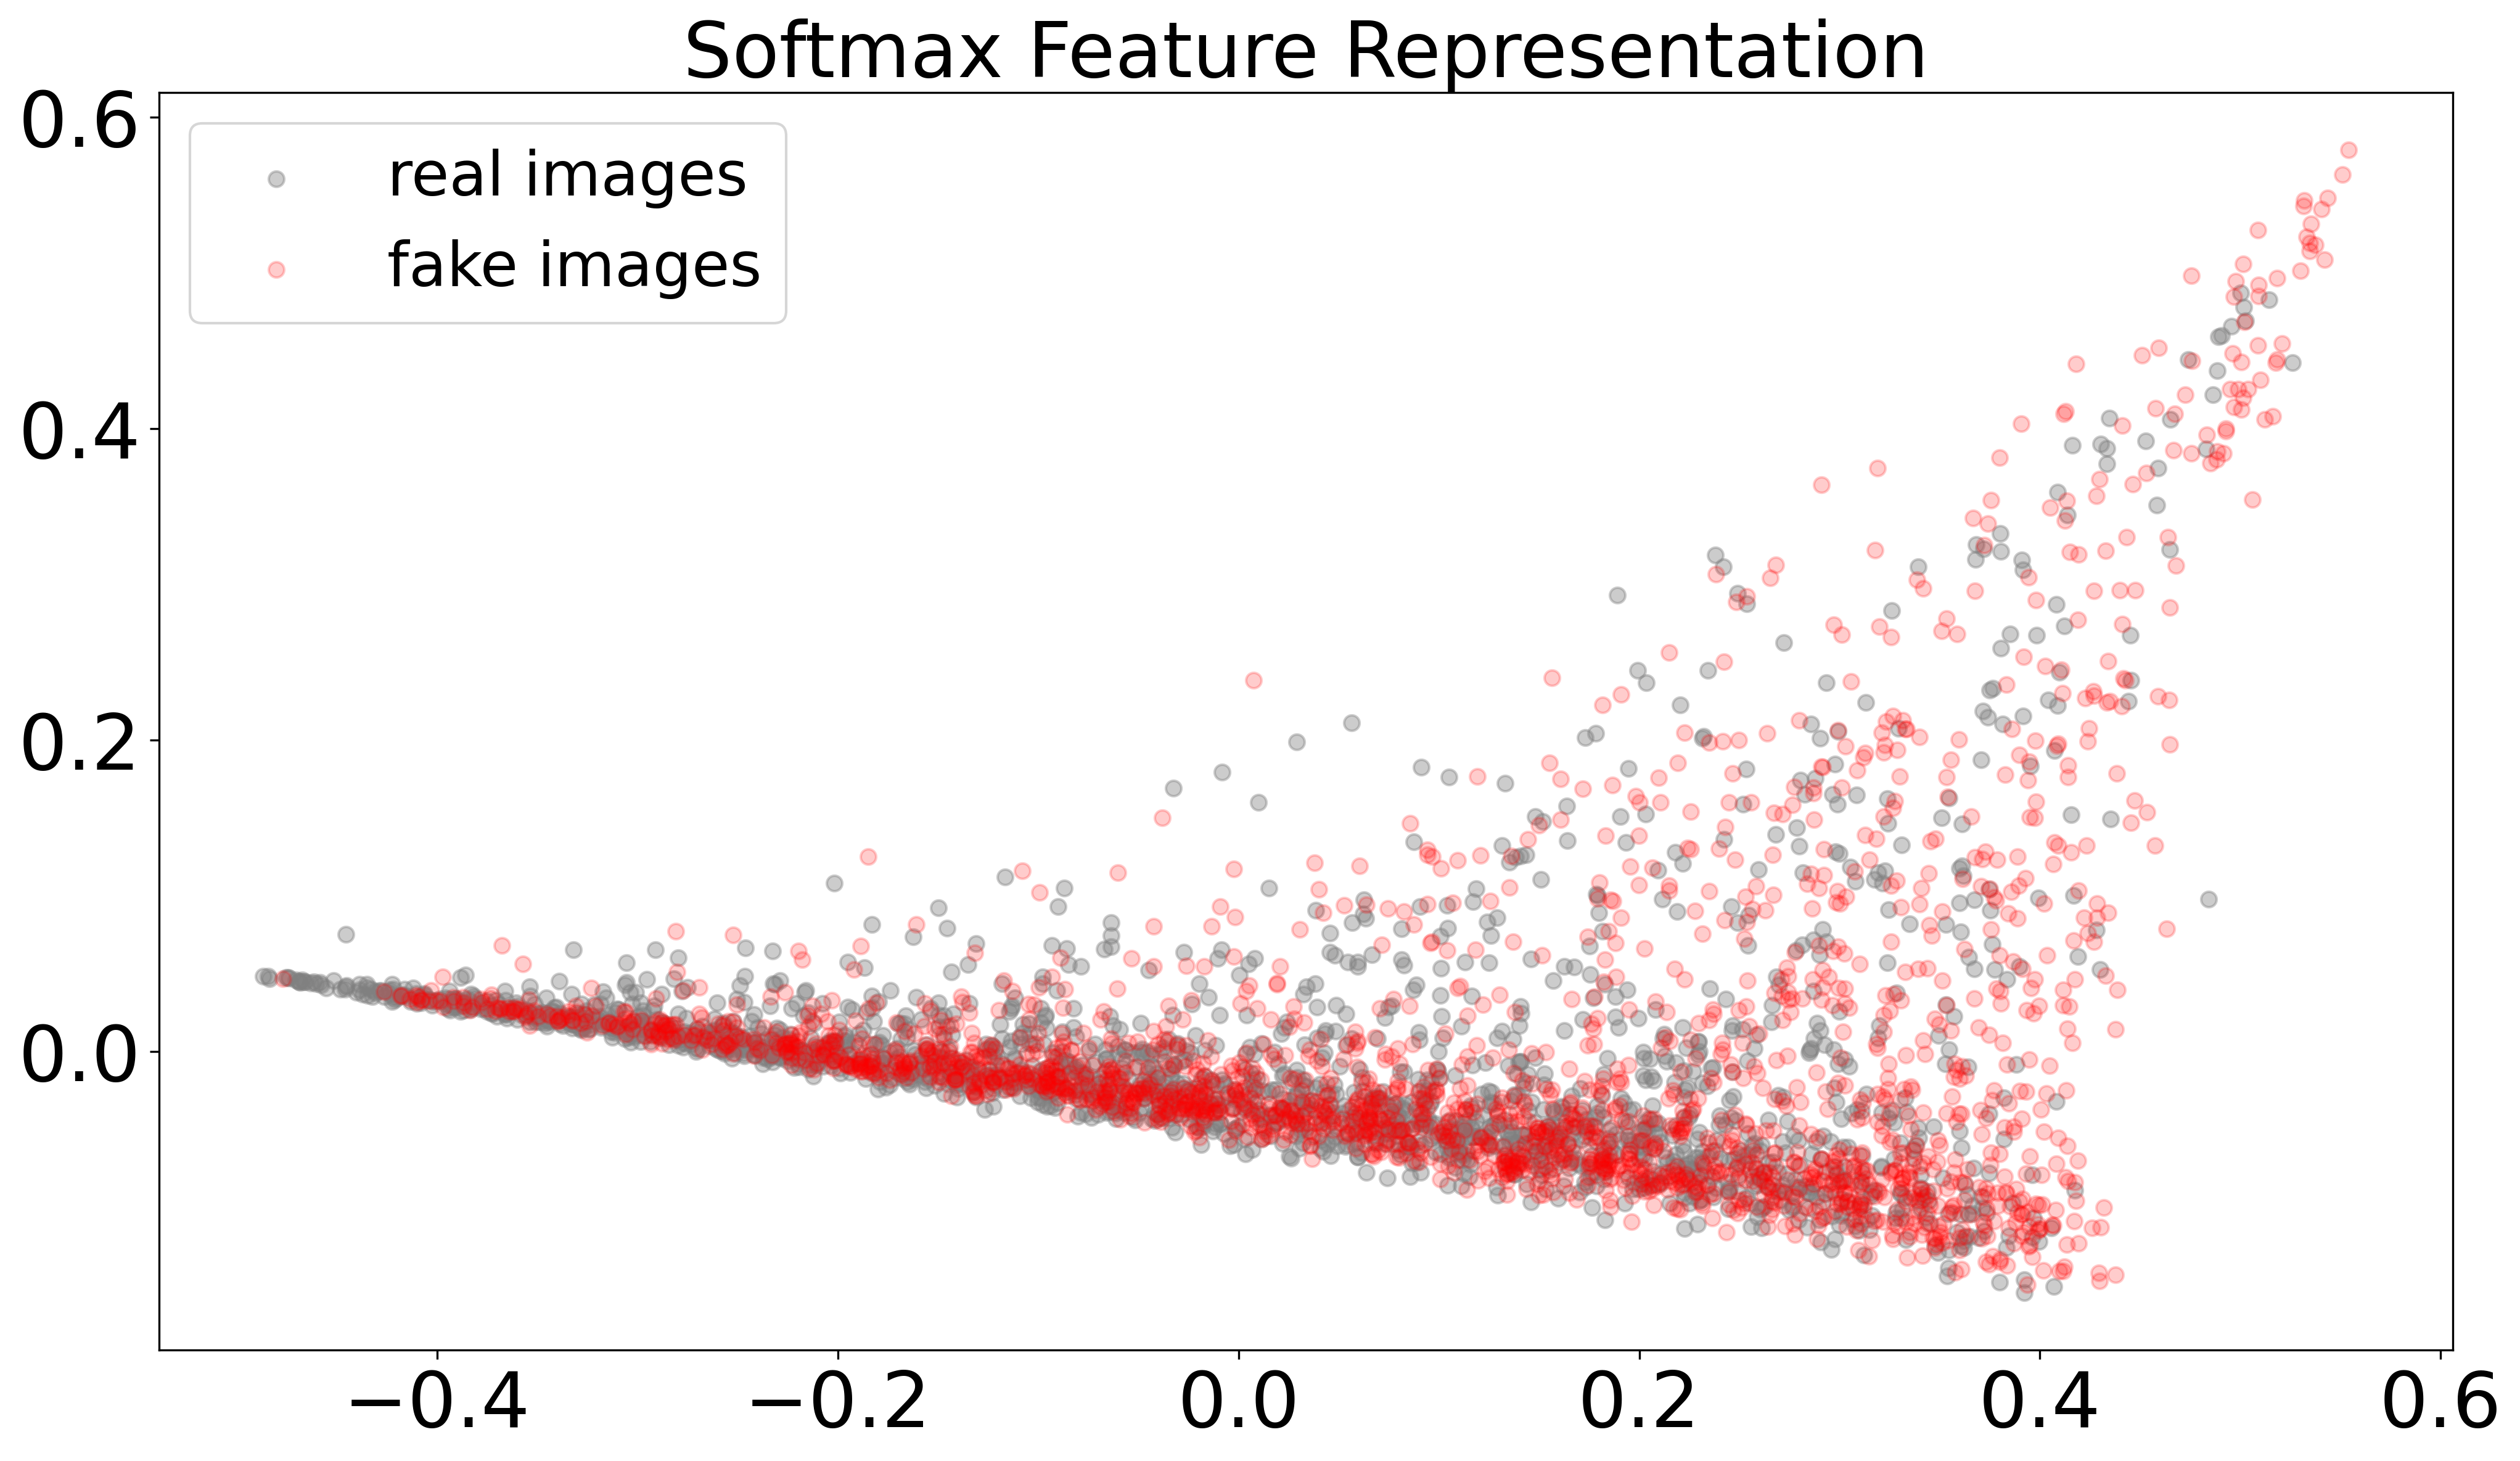

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=300)
ax.scatter(pca_f['real']['smax'][:,0],pca_f['real']['smax'][:,1], label='real images', alpha=0.4, c='gray')
ax.scatter(pca_f['fake']['smax'][:,0],pca_f['fake']['smax'][:,1], label='fake images',alpha=0.2, color='red')

ax.tick_params(axis="x", labelsize=30)
ax.tick_params(axis="y", labelsize=30)

ax.legend(fontsize='24')
plt.title('Softmax Feature Representation', fontsize=30)
plt.show()

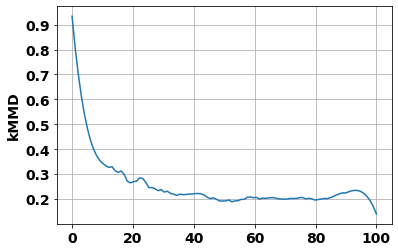

In [8]:
# plot mmd:
offset = 1
loss_num = 7
# Parameters
x = np.linspace(0, epoch_n, epoch_n)

# Smooth the data using Savitzky-Golay filter
window_size = min(21,find_maximum_odd_numebr(epoch_n))  # Choose an odd number
polynomial_order = 3  # Usually 3 is used
smoothed_data = savgol_filter(score_tr[:,3*loss_num+offset][:epoch_n], window_size, polynomial_order)

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(x, smoothed_data)
plt.ylabel("GAN training epoch", fontweight='bold', fontsize=14)
plt.ylabel("kMMD", fontweight='bold', fontsize=14)

# For tick marks:
tickKwargs = {'fontweight': 'bold', 'fontsize': 14}
plt.xticks(**tickKwargs)
plt.yticks(**tickKwargs)

plt.grid()
plt.show()

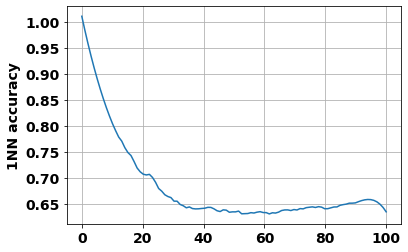

In [9]:
# plot 1nn acc:
offset = 2
loss_num = 7
# Parameters
x = np.linspace(0, epoch_n, epoch_n)

# Smooth the data using Savitzky-Golay filter
window_size = min(21,find_maximum_odd_numebr(epoch_n))  # Choose an odd number
polynomial_order = 3  # Usually 3 is used
smoothed_data = savgol_filter(score_tr[:,3*loss_num+offset][:epoch_n], window_size, polynomial_order)

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(x, smoothed_data)
plt.ylabel("GAN training epoch", fontweight='bold', fontsize=14)
plt.ylabel("1NN accuracy", fontweight='bold', fontsize=14)

# For tick marks:
tickKwargs = {'fontweight': 'bold', 'fontsize': 14}
plt.xticks(**tickKwargs)
plt.yticks(**tickKwargs)

plt.grid()
plt.show()

In [10]:
# generate confidence scores

# generate sample images using GAN checkpoints
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_path = G_model+'/'


for i in range(4,epoch_n,5):
    model_name = 'netG_epoch_'+str(i)+'.pth'
    G_path = model_path+model_name
    size = 2000
    save_path = G_model+'/test/'+model_name
    generate_fake(params,G_path,device,size,save_path)

sampling fake images ...


100%|██████████| 63/63 [00:09<00:00,  6.54it/s]


finish generating fake data
sampling fake images ...


100%|██████████| 63/63 [00:08<00:00,  7.22it/s]


finish generating fake data
sampling fake images ...


100%|██████████| 63/63 [00:07<00:00,  8.27it/s]


finish generating fake data
sampling fake images ...


100%|██████████| 63/63 [00:07<00:00,  8.03it/s]


finish generating fake data
sampling fake images ...


100%|██████████| 63/63 [00:08<00:00,  7.48it/s]


finish generating fake data
sampling fake images ...


100%|██████████| 63/63 [00:07<00:00,  8.00it/s]


finish generating fake data
sampling fake images ...


100%|██████████| 63/63 [00:07<00:00,  8.10it/s]


finish generating fake data
sampling fake images ...


100%|██████████| 63/63 [00:08<00:00,  7.31it/s]


finish generating fake data
sampling fake images ...


100%|██████████| 63/63 [00:08<00:00,  7.65it/s]


finish generating fake data
sampling fake images ...


100%|██████████| 63/63 [00:08<00:00,  7.46it/s]


finish generating fake data
sampling fake images ...


100%|██████████| 63/63 [00:08<00:00,  7.61it/s]


finish generating fake data
sampling fake images ...


100%|██████████| 63/63 [00:07<00:00,  8.13it/s]


finish generating fake data
sampling fake images ...


100%|██████████| 63/63 [00:07<00:00,  8.29it/s]


finish generating fake data
sampling fake images ...


100%|██████████| 63/63 [00:08<00:00,  7.38it/s]


finish generating fake data
sampling fake images ...


100%|██████████| 63/63 [00:09<00:00,  6.83it/s]


finish generating fake data
sampling fake images ...


100%|██████████| 63/63 [00:08<00:00,  7.25it/s]


finish generating fake data
sampling fake images ...


100%|██████████| 63/63 [00:08<00:00,  7.61it/s]


finish generating fake data
sampling fake images ...


100%|██████████| 63/63 [00:08<00:00,  7.79it/s]


finish generating fake data
sampling fake images ...


100%|██████████| 63/63 [00:08<00:00,  7.39it/s]


finish generating fake data
sampling fake images ...


100%|██████████| 63/63 [00:08<00:00,  7.26it/s]

finish generating fake data


In [11]:
score_array = []
common_dir = G_model+'/test/'
for i in range(4,epoch_n,5):
    model_name = 'netG_epoch_'+str(i)+'.pth'
    val_dir = common_dir+model_name+'/'
    scores = positive_score(val_dir,1,CNN_model_path)
    score_array.append(scores)

2023-08-29 00:16:03.388529: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-08-29 00:16:03.388826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-29 00:16:03.389117: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1666] Found device 0 with properties: 
name: NVIDIA RTX A6000 major: 8 minor: 6 memoryClockRate(GHz): 1.8
pciBusID: 0000:01:00.0
2023-08-29 00:16:03.389174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-29 00:16:03.389336: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1666] Found device 1 with properties: 
name: NVIDIA RTX A6000 major: 8 minor: 6 memoryClockRate(GHz): 1.8
pciBusID: 0000:4b:00.0
2

2023-08-29 00:16:08.920351: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


In [12]:
score_mean = []
score_var = []
for arr in score_array:
    score_mean.append(np.mean(np.array(arr),axis=0)[1])
    score_var.append(np.std(np.array(arr),axis=0)[1])

In [13]:
score_mean = np.array(score_mean)
score_var = np.array(score_var)

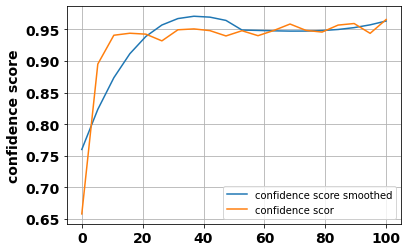

In [14]:
from scipy.signal import savgol_filter

# Parameters
x = np.linspace(0, epoch_n, epoch_n//5)

# Smooth the data using Savitzky-Golay filter
window_size = min(21,find_maximum_odd_numebr(epoch_n//5))  # Choose an odd number
polynomial_order = 3  # Usually 3 is used
smoothed_data = savgol_filter(score_mean, window_size, polynomial_order)

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(x, smoothed_data, label='confidence score smoothed')
plt.plot(x, score_mean, label='confidence scor')

plt.ylabel("confidence score", fontweight='bold', fontsize=14)

# For tick marks:
tickKwargs = {'fontweight': 'bold', 'fontsize': 14}
plt.xticks(**tickKwargs)
plt.yticks(**tickKwargs)

plt.grid()
plt.legend()
plt.show()